In [1]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, roc_curve, auc
import kagglehub
import os
import torch
from torchvision.datasets import ImageFolder
from torchvision import transforms, models
from torch.utils.data import DataLoader, random_split, ConcatDataset, Subset
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from google.colab import drive
import random
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from tqdm import tqdm
from collections import Counter


In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
seed = 2025
torch.manual_seed(seed), np.random.seed(seed), random.seed(seed)

(<torch._C.Generator at 0x783ab6906d30>, None, None)

In [4]:
def handpd_loaders_with_CV(path, k = 3):

    # reformat, RGB default Normalize parameters
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.225, 0.225, 0.225])
    # input size not specified, stick with default 224 * 224
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        normalize
    ])

    full_dataset = ImageFolder(path, transform = transform)
    # 0 Heallthy and 1 patient
    labels = np.array(full_dataset.targets)

    # 80-20 split for each dataset
    train_idx, test_idx = train_test_split(
        np.arange(len(full_dataset)),
        test_size = 0.2,
        random_state = seed,
        stratify = labels)

    # form dataset
    train_dataset = Subset(full_dataset, train_idx)
    test_dataset = Subset(full_dataset, test_idx)


    #  test loaders
    test_loader  = DataLoader(test_dataset, batch_size = 32, shuffle = False, pin_memory = True)

    # properties
    print(f"Total samples: {len(full_dataset)}")
    print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")
    print(f"Classes: {full_dataset.classes}")

    # 3-fold CV
    train_labels = labels[train_idx]
    kfold = StratifiedKFold(n_splits = k, shuffle = True, random_state = seed)

    positions = np.arange(len(train_dataset))

    fold_loader = []
    for fold, (train_fold_idx, val_fold_idx) in enumerate(kfold.split(positions, train_labels)):
        train_select = Subset(train_dataset, train_fold_idx)
        val_select = Subset(train_dataset, val_fold_idx)

        train_loader = DataLoader(train_select, batch_size = 32, shuffle = True, pin_memory = True)
        val_loader = DataLoader(val_select, batch_size = 32, shuffle = True, pin_memory = True)
        fold_loader.append((train_loader, val_loader))
        print(f"Fold {fold+1}: Train {len(train_select)}, Val {len(val_select)}")

    return fold_loader, test_loader, full_dataset


In [5]:
base_path = '/content/drive/MyDrive/Class Materials/Fall 25/STOR566/STOR566Project/Parkinsons'
fold_loader, test_loader, full_dataset = handpd_loaders_with_CV(base_path)

Total samples: 3264
Train samples: 2611, Test samples: 653
Classes: ['Healthy', 'Parkinson']
Fold 1: Train 1740, Val 871
Fold 2: Train 1741, Val 870
Fold 3: Train 1741, Val 870


In [6]:
counts = Counter(full_dataset.targets)
print("Class index mapping:", full_dataset.class_to_idx)
print("Total distribution:", counts)

Class index mapping: {'Healthy': 0, 'Parkinson': 1}
Total distribution: Counter({0: 1632, 1: 1632})


In [7]:
example_train, example_val = fold_loader[0]
images, labels = next(iter(example_train))
dataset = ImageFolder(base_path)
# labels -- 0(healthy) or 1(Parkinson)
print(images.shape, labels.shape)
print(dataset.classes)

torch.Size([32, 3, 224, 224]) torch.Size([32])
['Healthy', 'Parkinson']


In [8]:
class mobilenet_v2(nn.Module):
  def __init__(self, num_classes = 2):
    super(mobilenet_v2, self).__init__()

    self.mnv2 = models.mobilenet_v2(pretrained = True)

    self.mnv2.classifier = nn.Sequential(
            nn.Linear(1280, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
    )

  def forward(self, x):
    return self.mnv2(x)


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
mnv_model = mobilenet_v2(num_classes = len(dataset.classes)).to(device)
print(mnv_model)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 132MB/s]

mobilenet_v2(
  (mnv2): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1, 

In [13]:
learning_rate = 1e-4
num_of_epoch  = 20
loss_fn = nn.CrossEntropyLoss()

# trackers
mnv_train_loss_tracker = []
mnv_val_acc_tracker = []


for fold, (train_loader, val_loader) in enumerate(fold_loader):
  print(f"\n --- Fold {fold+1} ---")
  # reset model for each fold
  mnv_model = mobilenet_v2(num_classes = len(dataset.classes)).to(device)
  mnv_optimizer = torch.optim.Adam(mnv_model.parameters(), lr = learning_rate)

  mnv_fold_train_loss = []
  mnv_fold_val_correct = []

  for epoch in tqdm(range(num_of_epoch)):
    mnv_model.train()
    mnv_train_sample_total = 0
    mnv_running_loss = 0.0
    # training
    for images, labels in train_loader:
      images, labels = images.to(device), labels.to(device)

      mnv_optimizer.zero_grad()
      mnv_outputs = mnv_model(images)
      mnv_loss = loss_fn(mnv_outputs, labels)
      mnv_loss.backward()
      mnv_optimizer.step()
      # store for plots
      mnv_train_sample_total += images.size(0)
      mnv_running_loss += mnv_loss.item() * images.size(0)

    mnv_epoch_train_loss = mnv_running_loss / mnv_train_sample_total
    mnv_fold_train_loss.append(mnv_epoch_train_loss)


    # validation accuracy
    mnv_model.eval()
    mnv_correct = 0
    mnv_total = 0
    with torch.no_grad():
      for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = mnv_model(images)
        _,preds = torch.max(outputs, 1)
        mnv_total += labels.size(0)
        mnv_correct += (preds == labels).sum().item()
    # Output stats
    mnv_epoch_accuracy = mnv_correct / mnv_total
    mnv_fold_val_correct.append(mnv_epoch_accuracy)

    print(f"Epoch [{epoch+1}/{num_of_epoch}] - "
          f"Train Loss: {mnv_epoch_train_loss:.4f} |"
          f" Val Accuracy: {mnv_epoch_accuracy:.4f}")


  mnv_train_loss_tracker.append(mnv_fold_train_loss)
  mnv_val_acc_tracker.append(mnv_fold_val_correct)


 --- Fold 1 ---


  5%|▌         | 1/20 [00:26<08:30, 26.87s/it]

Epoch [1/20] - Train Loss: 0.4499 | Val Accuracy: 0.8691


 10%|█         | 2/20 [00:59<08:59, 29.98s/it]

Epoch [2/20] - Train Loss: 0.1909 | Val Accuracy: 0.9323


 15%|█▌        | 3/20 [01:29<08:29, 29.99s/it]

Epoch [3/20] - Train Loss: 0.0910 | Val Accuracy: 0.9633


 20%|██        | 4/20 [02:03<08:27, 31.70s/it]

Epoch [4/20] - Train Loss: 0.0629 | Val Accuracy: 0.9541


 25%|██▌       | 5/20 [02:40<08:23, 33.57s/it]

Epoch [5/20] - Train Loss: 0.0558 | Val Accuracy: 0.9541


 30%|███       | 6/20 [03:09<07:31, 32.27s/it]

Epoch [6/20] - Train Loss: 0.0377 | Val Accuracy: 0.9633


 35%|███▌      | 7/20 [03:36<06:36, 30.52s/it]

Epoch [7/20] - Train Loss: 0.0339 | Val Accuracy: 0.9529


 40%|████      | 8/20 [04:04<05:55, 29.64s/it]

Epoch [8/20] - Train Loss: 0.0397 | Val Accuracy: 0.9564


 45%|████▌     | 9/20 [04:32<05:19, 29.07s/it]

Epoch [9/20] - Train Loss: 0.0393 | Val Accuracy: 0.9644


 50%|█████     | 10/20 [04:59<04:42, 28.30s/it]

Epoch [10/20] - Train Loss: 0.0339 | Val Accuracy: 0.9679


 55%|█████▌    | 11/20 [05:25<04:10, 27.82s/it]

Epoch [11/20] - Train Loss: 0.0091 | Val Accuracy: 0.9759


 60%|██████    | 12/20 [05:52<03:40, 27.51s/it]

Epoch [12/20] - Train Loss: 0.0135 | Val Accuracy: 0.9690


 65%|██████▌   | 13/20 [06:20<03:13, 27.64s/it]

Epoch [13/20] - Train Loss: 0.0904 | Val Accuracy: 0.9770


 70%|███████   | 14/20 [06:47<02:43, 27.30s/it]

Epoch [14/20] - Train Loss: 0.0235 | Val Accuracy: 0.9736


 75%|███████▌  | 15/20 [07:13<02:15, 27.08s/it]

Epoch [15/20] - Train Loss: 0.0326 | Val Accuracy: 0.9701


 80%|████████  | 16/20 [07:40<01:47, 26.89s/it]

Epoch [16/20] - Train Loss: 0.0163 | Val Accuracy: 0.9793


 85%|████████▌ | 17/20 [08:05<01:19, 26.58s/it]

Epoch [17/20] - Train Loss: 0.0027 | Val Accuracy: 0.9793


 90%|█████████ | 18/20 [08:32<00:53, 26.53s/it]

Epoch [18/20] - Train Loss: 0.0031 | Val Accuracy: 0.9793


 95%|█████████▌| 19/20 [08:58<00:26, 26.47s/it]

Epoch [19/20] - Train Loss: 0.0042 | Val Accuracy: 0.9828


100%|██████████| 20/20 [09:25<00:00, 28.26s/it]

Epoch [20/20] - Train Loss: 0.0079 | Val Accuracy: 0.9736

 --- Fold 2 ---



  5%|▌         | 1/20 [00:26<08:26, 26.64s/it]

Epoch [1/20] - Train Loss: 0.4601 | Val Accuracy: 0.9023


 10%|█         | 2/20 [00:53<08:01, 26.75s/it]

Epoch [2/20] - Train Loss: 0.2163 | Val Accuracy: 0.9575


 15%|█▌        | 3/20 [01:20<07:33, 26.66s/it]

Epoch [3/20] - Train Loss: 0.1284 | Val Accuracy: 0.9667


 20%|██        | 4/20 [01:47<07:11, 26.96s/it]

Epoch [4/20] - Train Loss: 0.0667 | Val Accuracy: 0.9690


 25%|██▌       | 5/20 [02:14<06:44, 27.00s/it]

Epoch [5/20] - Train Loss: 0.0463 | Val Accuracy: 0.9632


 30%|███       | 6/20 [02:41<06:16, 26.90s/it]

Epoch [6/20] - Train Loss: 0.0312 | Val Accuracy: 0.9724


 35%|███▌      | 7/20 [03:07<05:47, 26.76s/it]

Epoch [7/20] - Train Loss: 0.0638 | Val Accuracy: 0.9690


 40%|████      | 8/20 [03:34<05:21, 26.76s/it]

Epoch [8/20] - Train Loss: 0.0428 | Val Accuracy: 0.9759


 45%|████▌     | 9/20 [04:01<04:54, 26.80s/it]

Epoch [9/20] - Train Loss: 0.0540 | Val Accuracy: 0.9793


 50%|█████     | 10/20 [04:28<04:27, 26.76s/it]

Epoch [10/20] - Train Loss: 0.0093 | Val Accuracy: 0.9862


 55%|█████▌    | 11/20 [04:54<04:00, 26.74s/it]

Epoch [11/20] - Train Loss: 0.0061 | Val Accuracy: 0.9874


 60%|██████    | 12/20 [05:21<03:33, 26.72s/it]

Epoch [12/20] - Train Loss: 0.0161 | Val Accuracy: 0.9816


 65%|██████▌   | 13/20 [05:48<03:07, 26.73s/it]

Epoch [13/20] - Train Loss: 0.0224 | Val Accuracy: 0.9805


 70%|███████   | 14/20 [06:14<02:40, 26.70s/it]

Epoch [14/20] - Train Loss: 0.0288 | Val Accuracy: 0.9621


 75%|███████▌  | 15/20 [06:41<02:13, 26.69s/it]

Epoch [15/20] - Train Loss: 0.0266 | Val Accuracy: 0.9701


 80%|████████  | 16/20 [07:08<01:47, 26.77s/it]

Epoch [16/20] - Train Loss: 0.0260 | Val Accuracy: 0.9736


 85%|████████▌ | 17/20 [07:35<01:20, 26.72s/it]

Epoch [17/20] - Train Loss: 0.0213 | Val Accuracy: 0.9747


 90%|█████████ | 18/20 [08:01<00:53, 26.77s/it]

Epoch [18/20] - Train Loss: 0.0107 | Val Accuracy: 0.9759


 95%|█████████▌| 19/20 [08:28<00:26, 26.66s/it]

Epoch [19/20] - Train Loss: 0.0043 | Val Accuracy: 0.9805


100%|██████████| 20/20 [08:54<00:00, 26.75s/it]


Epoch [20/20] - Train Loss: 0.0277 | Val Accuracy: 0.9793

 --- Fold 3 ---


  5%|▌         | 1/20 [00:26<08:28, 26.74s/it]

Epoch [1/20] - Train Loss: 0.4290 | Val Accuracy: 0.9161


 10%|█         | 2/20 [00:53<08:01, 26.77s/it]

Epoch [2/20] - Train Loss: 0.1963 | Val Accuracy: 0.8805


 15%|█▌        | 3/20 [01:20<07:33, 26.68s/it]

Epoch [3/20] - Train Loss: 0.1088 | Val Accuracy: 0.9448


 20%|██        | 4/20 [01:46<07:06, 26.63s/it]

Epoch [4/20] - Train Loss: 0.0767 | Val Accuracy: 0.9402


 25%|██▌       | 5/20 [02:13<06:39, 26.64s/it]

Epoch [5/20] - Train Loss: 0.0421 | Val Accuracy: 0.9644


 30%|███       | 6/20 [02:40<06:14, 26.72s/it]

Epoch [6/20] - Train Loss: 0.0879 | Val Accuracy: 0.9506


 35%|███▌      | 7/20 [03:06<05:47, 26.73s/it]

Epoch [7/20] - Train Loss: 0.0463 | Val Accuracy: 0.9770


 40%|████      | 8/20 [03:33<05:21, 26.78s/it]

Epoch [8/20] - Train Loss: 0.0363 | Val Accuracy: 0.9839


 45%|████▌     | 9/20 [04:00<04:54, 26.73s/it]

Epoch [9/20] - Train Loss: 0.0164 | Val Accuracy: 0.9667


 50%|█████     | 10/20 [04:27<04:27, 26.70s/it]

Epoch [10/20] - Train Loss: 0.0142 | Val Accuracy: 0.9828


 55%|█████▌    | 11/20 [04:53<04:00, 26.70s/it]

Epoch [11/20] - Train Loss: 0.0128 | Val Accuracy: 0.9644


 60%|██████    | 12/20 [05:20<03:33, 26.71s/it]

Epoch [12/20] - Train Loss: 0.0356 | Val Accuracy: 0.9356


 65%|██████▌   | 13/20 [05:46<03:06, 26.62s/it]

Epoch [13/20] - Train Loss: 0.0406 | Val Accuracy: 0.9816


 70%|███████   | 14/20 [06:13<02:39, 26.65s/it]

Epoch [14/20] - Train Loss: 0.0238 | Val Accuracy: 0.9609


 75%|███████▌  | 15/20 [06:40<02:12, 26.57s/it]

Epoch [15/20] - Train Loss: 0.0151 | Val Accuracy: 0.9874


 80%|████████  | 16/20 [07:06<01:46, 26.54s/it]

Epoch [16/20] - Train Loss: 0.0182 | Val Accuracy: 0.9609


 85%|████████▌ | 17/20 [07:32<01:19, 26.52s/it]

Epoch [17/20] - Train Loss: 0.0191 | Val Accuracy: 0.9839


 90%|█████████ | 18/20 [07:59<00:52, 26.49s/it]

Epoch [18/20] - Train Loss: 0.0065 | Val Accuracy: 0.9920


 95%|█████████▌| 19/20 [08:25<00:26, 26.48s/it]

Epoch [19/20] - Train Loss: 0.0076 | Val Accuracy: 0.9862


100%|██████████| 20/20 [08:52<00:00, 26.61s/it]

Epoch [20/20] - Train Loss: 0.0076 | Val Accuracy: 0.9931


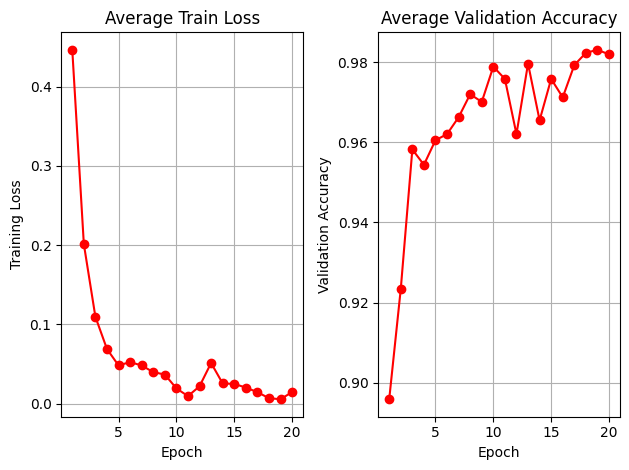

In [18]:
#CCNet
mnv_avg_train_loss = [sum(epoch)/len(epoch) for epoch in zip(*mnv_train_loss_tracker)]
mnv_avg_val_acc = [sum(epoch)/len(epoch) for epoch in zip(*mnv_val_acc_tracker)]

# Averged 3 Fold Loss Per Epoch
plt.subplot(1,2,1)  # 1 row, 2 columns, first plot
plt.plot(range(1, len(mnv_avg_train_loss)+1), mnv_avg_train_loss, marker='o', color='red')
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Average Train Loss")
plt.grid(True)

# Average 3 Fold Accuracy Per Epoch
plt.subplot(1,2,2)  # 1 row, 2 columns, second plot
plt.plot(range(1, len(mnv_avg_val_acc)+1), mnv_avg_val_acc, marker='o', color='red')
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Average Validation Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()

# Testing

In [16]:
mnv_model.eval()

predictions = []
probabilities = []
true_labels = []
with torch.no_grad():
    for images, labels in test_loader:
      images, labels = images.to(device), labels.to(device)
      # raw logit
      logits = mnv_model(images)
      _, preds = torch.max(logits, 1)
      prob = torch.nn.functional.softmax(logits, dim=1)[:,1]

      predictions.extend(preds.cpu().numpy())
      probabilities.extend(prob.cpu().numpy())
      true_labels.extend(labels.cpu().numpy())

# Test Metrics
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)
mcc = matthews_corrcoef(true_labels, predictions)

print("Test Metrics:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"MCC:       {mcc:.4f}")


Test Metrics:
Accuracy:  0.9862
Precision: 0.9847
Recall:    0.9877
F1 Score:  0.9862
MCC:       0.9724


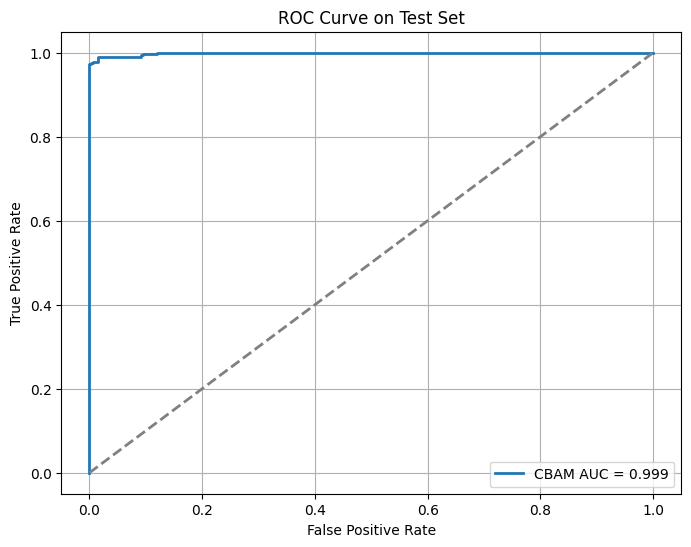

In [17]:
# ROC Curve
# copy to memory
#cbam
labels_np = true_labels.cpu().numpy() if torch.is_tensor(true_labels) else true_labels
probabilities_np = probabilities.cpu().numpy() if torch.is_tensor(probabilities) else probabilities
false_positive, true_positive, threshold = roc_curve(labels_np, probabilities_np)
roc_auc = auc(false_positive, true_positive)


plt.figure(figsize=(8,6))
plt.plot(false_positive, true_positive, lw=2, label=f'CBAM AUC = {roc_auc:.3f}')
plt.plot([0,1],[0,1], color='gray', linestyle='--', lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve on Test Set")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()